In [1]:
import time
import torch
from torch import nn
import re

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# функция, днлающая последовательность цифр, по заданым в зании правилам. N - длина последовательности. 
N = 50
def make_sequense(N):
    X = torch.zeros(N)
    Y = torch.zeros(N)
    Y[0] =  X[0] = torch.randint(10, (1,))
    for i in range(1, N):
        X[i] = torch.randint(10, (1,))
        y = X[i] + X[1]
        if y >= 10:
            Y[i] = y - 10
        else:
            Y[i] = y
    return X, Y     

In [3]:
# демонстрация работы функции, деляющей последовательность
X_, Y_ = make_sequense(N)
print(X_[:100])
print(Y_[:100])

tensor([0., 5., 2., 4., 5., 5., 5., 6., 4., 8., 7., 7., 0., 9., 6., 4., 3., 7.,
        6., 8., 9., 7., 3., 3., 3., 9., 0., 8., 4., 7., 0., 1., 1., 0., 8., 7.,
        6., 8., 2., 0., 1., 6., 4., 3., 7., 2., 8., 4., 8., 2.])
tensor([0., 0., 7., 9., 0., 0., 0., 1., 9., 3., 2., 2., 5., 4., 1., 9., 8., 2.,
        1., 3., 4., 2., 8., 8., 8., 4., 5., 3., 9., 2., 5., 6., 6., 5., 3., 2.,
        1., 3., 7., 5., 6., 1., 9., 8., 2., 7., 3., 9., 3., 7.])


In [4]:
# функция, собирающая датасет
# N - длина строки (последовательности), rows - количество строк, BATCH_SIZE - размер батча
def make_dataset(rows, N, BATCH_SIZE = 500):
    X = torch.zeros(rows, N)
    Y = torch.zeros(rows, N)
    for item in range(rows):
        X[item], Y[item] = make_sequense(N)
    
    X = X.view(rows, N)
    Y = Y.view(rows, N) 

    dataset = torch.utils.data.TensorDataset(X, Y)
    data = torch.utils.data.DataLoader(dataset, BATCH_SIZE, shuffle=True)
    
    return data

In [5]:
# examples = 10000 # Всего пар X, Y
# N = 100
# rows = examples // N
# BATCH_SIZE = 50
# data = make_dataset(rows, N, BATCH_SIZE)
# print('Количество батчей - ', len(data), '\nОбщее количество строк - ', rows, '\nДлина последовательности в строке - ', N)

In [6]:
# нейроссеть
class NeuralNetwork(nn.Module):
    def __init__(self, rnnClass, input_size, hidden_layer_size, len_seq_num=10, output_size=1):
        super().__init__()
        
        self.hidden_layer_size = hidden_layer_size        
        self.emb = nn.Embedding(len_seq_num, 28)
        self.hidden = rnnClass(input_size, hidden_layer_size, batch_first=True)
        self.output = nn.Linear(hidden_layer_size, output_size)
        
        
    def forward(self, X, h_state=None):
        emb = self.emb(X.long())
        out, state = self.hidden(emb)
        result = self.output(out)
        return result

In [10]:
def test_net_loss_per_epoch(data, model, N_epoch, optimizer, criterion):
    loss_list = []
    for ep in range(N_epoch):
        start = time.time()
        train_loss = 0.
        train_passed = 0

        model.train()
        for X_b, y_b in data:
            X_b, y_b = X_b.cuda(), y_b.cuda()
            optimizer.zero_grad()
            answers = model(X_b)
            loss = criterion(answers.permute(0, 2, 1), y_b.long())
            train_loss +=loss.item()  
            loss.backward()
            optimizer.step()
            train_passed += 1
        loss_list.append(train_loss / train_passed)
    return np.array(loss_list)

In [11]:
def test_nets(models, Ns, N_epoch, examples, BATCH_SIZE):
    result = {}
    criterion = torch.nn.CrossEntropyLoss()
    
    for N in Ns:
        rows = examples // N
        BATCH_SIZE = BATCH_SIZE
        data = make_dataset(rows, N, BATCH_SIZE)       
        
        for item in models:
            model = NeuralNetwork(item, 28, 100, 10, 28)
            optimizer = torch.optim.Adam(model.parameters())
            model = model.cuda()            
            result[item.__name__.split('.')[-1] +'_'+ str(N)] = test_net_loss_per_epoch(data, model, N_epoch, optimizer, criterion)           
    return result

In [18]:
models = [nn.RNN, nn.GRU, nn.LSTM]
Ns = [10, 20, 50, 70, 100]
N_epoch = 800
examples = 40000
BATCH_SIZE = 100

result = test_nets(models, Ns, N_epoch, examples, BATCH_SIZE)

In [19]:
result.keys()

dict_keys(['RNN_10', 'GRU_10', 'LSTM_10', 'RNN_20', 'GRU_20', 'LSTM_20', 'RNN_50', 'GRU_50', 'LSTM_50', 'RNN_70', 'GRU_70', 'LSTM_70', 'RNN_100', 'GRU_100', 'LSTM_100'])

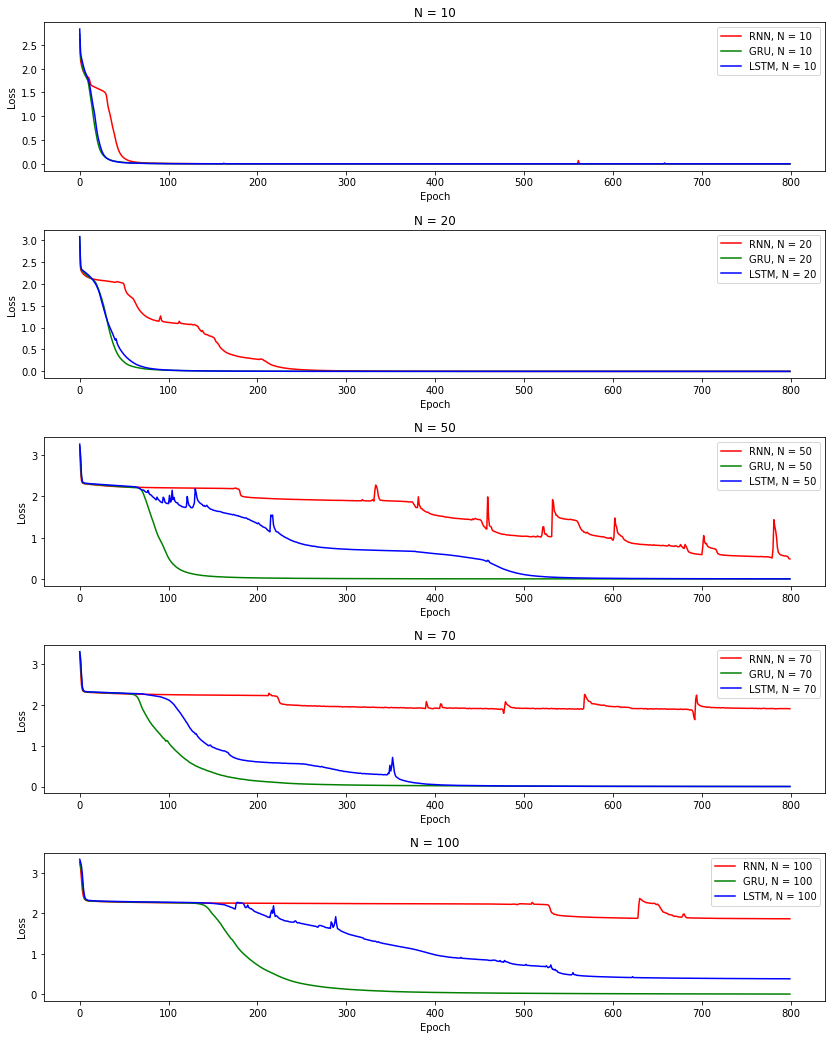

In [20]:
# Вместо таблицы, построю графики, они более наглядные.
models_name = [ item.__name__.split('.')[-1] for item in models]
colors = ['red', 'green', 'blue']

plt.figure(figsize=(14,18))
for ind, item in enumerate(Ns):
    legend = []
    plt.subplot(len(Ns), 1, ind + 1)
    plt.subplots_adjust(hspace=0.4)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    for i, name in enumerate(models_name):
        plt.plot(result[name + '_' + str(item)], color=colors[i])
        legend.append(name + ', N = ' + str(item))
    plt.title('N = ' + str(item))
    plt.legend(legend)
plt.show()